In [1]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.datasets import mnist

import sys
import os
sys.path.append(os.path.abspath('..'))
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping, simpleGrouping
from utils.load import inflectionpoint, gen_corr_matrix

2024-04-08 17:15:10.209133: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 17:15:10.210268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:15:10.231652: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:15:10.232300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 17:15:10.624108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
color = ["red", "yellow", "green", "brown", "orange", "navy", "royalblue"]
color2_2 = [["red", "blue"], ["darkorange", "royalblue"]]
reds = ["red", "orangered", "darkorange", "crimson"]
blues = ["blue", "navy","royalblue",  "deepskyblue"]
line = ["-","--","-.", ":"]

In [3]:
def generate_labeled_dataset(dimensions, num_samples, noise_ratio):
    # The total number of noise points
    num_noise = int(num_samples * noise_ratio)
    
    # The number of samples in each cluster
    num_cluster_samples = (num_samples - num_noise) // 2
    
    # Generate random centers for the two clusters
    center_1 = np.random.rand(dimensions)
    center_2 = 10 * np.random.rand(dimensions)
    
    # Generate the clusters around the random centers
    cluster_1 = center_1 + 3 * np.random.randn(num_cluster_samples, dimensions)
    cluster_2 = center_2 + 3 * np.random.randn(num_cluster_samples, dimensions)
    
    # Generate noise
    noise = np.vstack(((center_1 + 5 * np.random.randn(num_noise // 2, dimensions)),(center_2 + 5 * np.random.randn(num_noise - num_noise // 2, dimensions))))
    # noise = np.vstack(((center_1 + 1 * np.random.randn(num_noise // 2, dimensions)),(center_2 + 1 * np.random.randn(num_noise - num_noise // 2, dimensions))))
    
    # Create labels for the clusters and noise
    labels_cluster_1 = np.zeros(num_cluster_samples)
    labels_cluster_2 = np.ones(num_cluster_samples)
    labels_noise = 2 * np.ones(num_noise)
    
    # Combine the clusters and noise
    data = np.vstack((cluster_1, cluster_2, noise))
    labels = np.concatenate((labels_cluster_1, labels_cluster_2, labels_noise))
    
    # Shuffle the dataset to mix noise and clusters
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]
    
    # Return the dataset as (vector, label)
    dataset = list(zip(shuffled_data, shuffled_labels))
    
    return dataset


Infinite values in X: False
Max value in X: 20.30340405014632
Min value in X: -12.398508127017152
[[10.77406691  8.76062664  9.6953114  11.62296365 -0.16213703  3.47223284
   2.31881323  7.17945082 10.27397469 10.29830441  0.83687706  9.74183245
   3.16527321  0.25626821  4.07808596  5.74741206  8.73325765  3.25529571
   6.1970264   0.89438605  5.25868726  1.04431436  4.24401556  6.56447446
  -0.53428585  4.37011634  5.0170023  -0.9813263   3.41216451  7.89801399
   4.98547054  1.1532636 ]
 [ 8.69144825  4.13658183  5.37209505 14.78412089  6.29393747  3.80362163
   4.52919748  3.03643767  3.05902848  8.56857018 -0.02368243  9.3865611
   4.53236552  1.25042737  7.06598137  1.35113768  5.28775725  3.88652539
   3.0234442   4.51219668  4.34122085  7.06623931  1.48889415  2.90392622
   5.38051135  1.73363969 10.04337009  5.4737811  -2.12920475  0.04898171
   4.15675658  4.49448917]
 [-3.01796192 -4.37812308  4.06618564  4.63813009 -3.79354809  0.77327565
   1.86783632 -5.32402169  1.101533

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


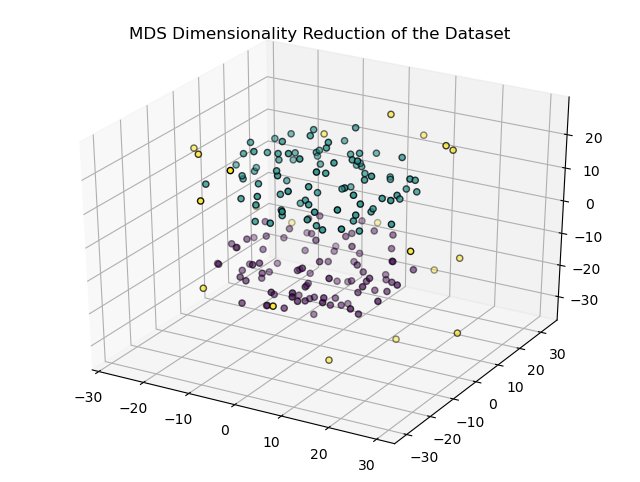

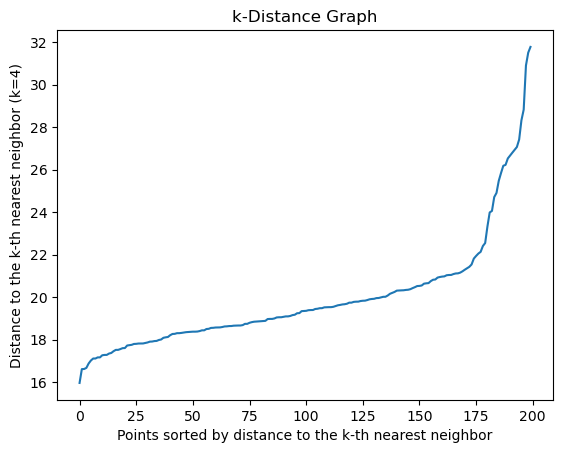

[[ 1.         22.62362745 35.121624   ... 24.96889501 40.97600358
  39.48517643]
 [22.62362745  1.         33.49208459 ... 22.0814759  38.38750309
  38.37369582]
 [35.121624   33.49208459  1.         ... 37.89929899 35.63775325
  21.03639375]
 ...
 [24.96889501 22.0814759  37.89929899 ...  1.         42.51961693
  39.77853378]
 [40.97600358 38.38750309 35.63775325 ... 42.51961693  1.
  37.90353447]
 [39.48517643 38.37369582 21.03639375 ... 39.77853378 37.90353447
   1.        ]]


In [4]:
%matplotlib inline
dimensions = 32  # Dimension of the feature vector
num_samples = 200  # Total number of samples
noise_ratio = 0.1  # Ratio of noise

# Generate the dataset with labels
labeled_dataset = generate_labeled_dataset(dimensions, num_samples, noise_ratio)

# Let's check the first few entries to confirm its structure
X, y = np.array([x[0] for x in labeled_dataset]), np.array([x[1] for x in labeled_dataset])
# Check for any infinite values

print("Infinite values in X:", np.any(np.isinf(X)))
# Check for any values that are too large
print("Max value in X:", np.max(X))
print("Min value in X:", np.min(X))

print(X[:5], y[:5])

sorted_distances = inflectionpoint(X)
mds = MDS(n_components=3, random_state=0)
X_mds = mds.fit_transform(X)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:,2], c=y, cmap='viridis', edgecolor='k')
plt.title("MDS Dimensionality Reduction of the Dataset")
# plt.xlabel("MDS1")
# plt.ylabel("MDS2")
# plt.colorbar(label='Class Label')
plt.show()

plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance to the k-th nearest neighbor')
plt.ylabel(f'Distance to the k-th nearest neighbor (k={4})')
plt.title('k-Distance Graph')
plt.show()
print(gen_corr_matrix(X))

In [47]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
dbscan = DBSCAN(eps=0.5, min_samples=5)
gmm = GaussianMixture(n_components=2, random_state=0)

In [48]:
labels_phg = simpleGrouping(gen_corr_matrix(X), 2, dbg=False)
labels_kmeans = kmeans.fit_predict(X)
labels_dbscan = dbscan.fit_predict(X)
labels_gmm = gmm.fit_predict(X)

print((labels_kmeans,labels_dbscan,labels_gmm,labels_phg))

(array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=int32), array([ 1,  1,  0,  1,  1,  0,  0,  1,  1,  1,  0,  0,  0,  1,  1,  0,  0,
        0,  0, -1,  0, -1,  0,  1, -1,  0,  1,  1,  1, -1,  0,  1,  1,  1,
        0,  1,  0, -1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1, -1,  0,
        1,  1,  0,  0,  1,  0,  1,  1,  0, -1,  0,  0, -1, -1,  0,  1,  1,
        0,  2,  1,  1,  1,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  2,  0,  1, -1,  0,  2,
        1,  0,  1,  0,  2,  0,  0,  0, -1,  0,  0,  0,  1,  0, -1,  1,  0,
        0]), array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0

In [49]:
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_dbscan = silhouette_score(X, labels_dbscan)
silhouette_gmm = silhouette_score(X, labels_gmm)
silhouette_phg = silhouette_score(X, labels_phg)

davies_bouldin_kmeans = davies_bouldin_score(X, labels_kmeans)
davies_bouldin_dbscan = davies_bouldin_score(X, labels_dbscan)
davies_bouldin_gmm = davies_bouldin_score(X, labels_gmm)
davies_bouldin_phg = davies_bouldin_score(X, labels_phg)

calinski_harabasz_kmeans = calinski_harabasz_score(X, labels_kmeans)
calinski_harabasz_dbscan = calinski_harabasz_score(X, labels_dbscan)
calinski_harabasz_gmm = calinski_harabasz_score(X, labels_gmm)
calinski_harabasz_phg = calinski_harabasz_score(X, labels_phg)

# 由于Mutual Information需要真实标签，我们使用测试集的一部分
# labels_true = [0]*90+[1]*90+[2]*20
labels_true = y
mutual_info_kmeans = mutual_info_score(labels_true, labels_kmeans)
mutual_info_dbscan = mutual_info_score(labels_true, labels_dbscan)
mutual_info_gmm = mutual_info_score(labels_true, labels_gmm)
mutual_info_phg = mutual_info_score(labels_true, labels_phg)

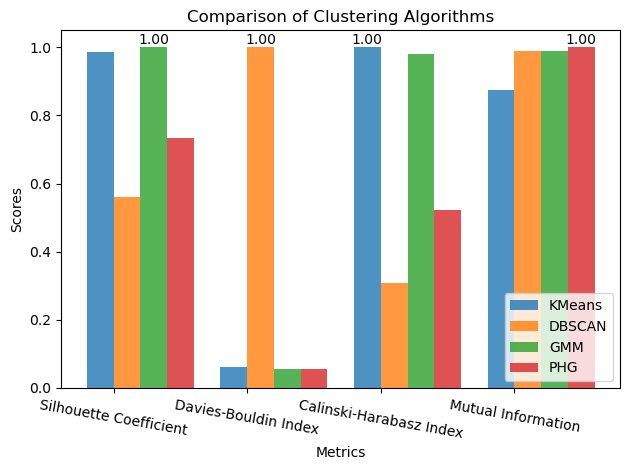

{'Silhouette Coefficient': {'KMeans': 0.9875765687086628, 'DBSCAN': 0.5612468888933582, 'GMM': 1.0, 'PHG': 0.7329498478747803}, 'Davies-Bouldin Index': {'KMeans': 0.06114764383068576, 'DBSCAN': 1.0, 'GMM': 0.05693048996046585, 'PHG': 0.056742480677126}, 'Calinski-Harabasz Index': {'KMeans': 1.0, 'DBSCAN': 0.3085603201768684, 'GMM': 0.9815501751100267, 'PHG': 0.5233576071566525}, 'Mutual Information': {'KMeans': 0.8762135754443781, 'DBSCAN': 0.9891807396367099, 'GMM': 0.99059589936522, 'PHG': 1.0}}


In [50]:
%matplotlib inline
# 定义评价指标和算法的数据
result = {
    "Silhouette Coefficient": {
        "KMeans": silhouette_kmeans,
        "DBSCAN": silhouette_dbscan,
        "GMM": silhouette_gmm,
        "PHG": silhouette_phg
    },
    "Davies-Bouldin Index": {
        "KMeans": davies_bouldin_kmeans,
        "DBSCAN": davies_bouldin_dbscan,
        "GMM": davies_bouldin_gmm,
        "PHG": davies_bouldin_phg
    },
    "Calinski-Harabasz Index": {
        "KMeans": calinski_harabasz_kmeans,
        "DBSCAN": calinski_harabasz_dbscan,
        "GMM": calinski_harabasz_gmm,
        "PHG": calinski_harabasz_phg
    },
    "Mutual Information": {
        "KMeans": mutual_info_kmeans,
        "DBSCAN": mutual_info_dbscan,
        "GMM": mutual_info_gmm,
        "PHG": mutual_info_phg
    }
}

normalized_data = {}
for metric, scores in result.items():
    if metric == 'Davies-Bouldin Index(Reversed)':
        min_value = min(scores.values())
        normalized_data[metric] = {algo: (score - min_value) / (max(scores.values()) - min_value) for algo, score in scores.items()}
    else:
        max_value = max(scores.values())
        normalized_data[metric] = {algo: score / max_value for algo, score in scores.items()}


# 转换数据格式以便绘图
metrics = list(normalized_data.keys())
algorithms = list(normalized_data[metrics[0]].keys())
scores = {algo: [normalized_data[metric][algo] for metric in metrics] for algo in algorithms}

# 计算每个指标的最佳得分
max_scores = {
    metric: max(normalized_data[metric].values())
    for metric in metrics
}

# 绘制条形图
fig, ax = plt.subplots()
plt.xticks(rotation=-10)
bar_width = 0.2
opacity = 0.8
index = np.arange(len(metrics))

for i, algo in enumerate(algorithms):
    bars = ax.bar(index + i * bar_width, scores[algo], bar_width, alpha=opacity, label=algo)
    # 为最佳得分添加红色标注
    for bar, score, metric in zip(bars, scores[algo], metrics):
        if score == max_scores[metric]:
            # bar.set_color('red')
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), '%.2f' % score, ha='center', va='bottom', color='black')

# 添加标签、标题和图例
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Clustering Algorithms')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend(loc="lower right")


# 展示图表
plt.tight_layout()
plt.show()

print(normalized_data)

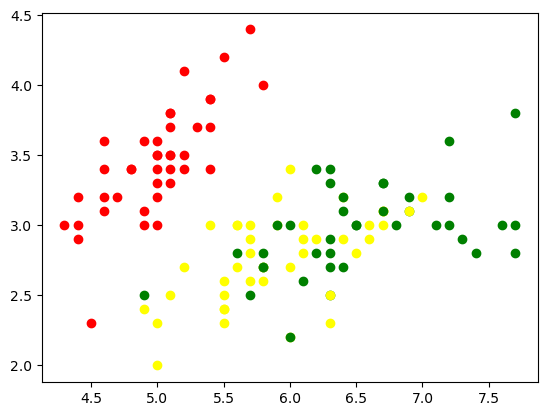

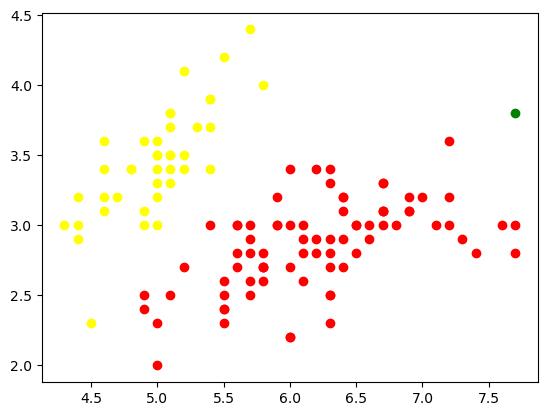

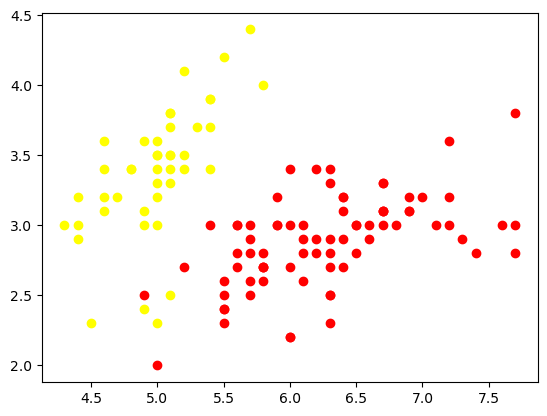

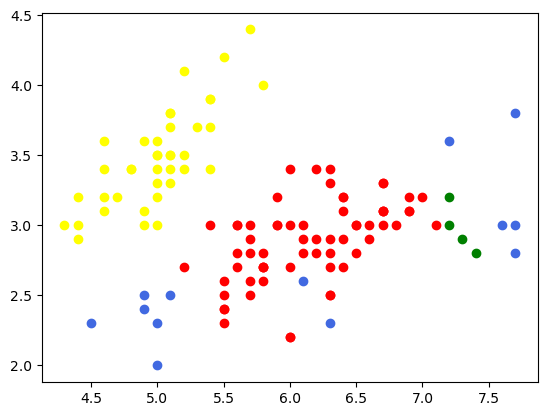

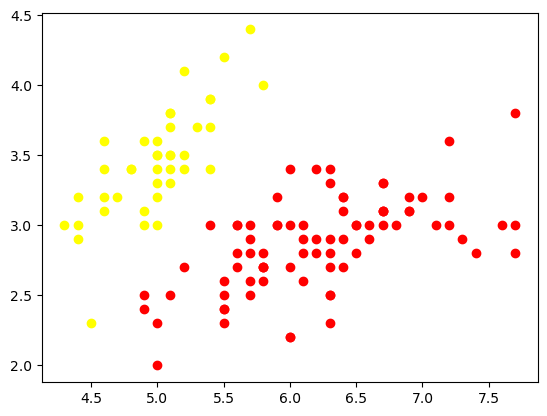

In [55]:
%matplotlib inline
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_true[idx]])
plt.show()
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_phg[idx]])
plt.show()
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_kmeans[idx]])
plt.show()
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_dbscan[idx]])
plt.show()
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_gmm[idx]])
plt.show()

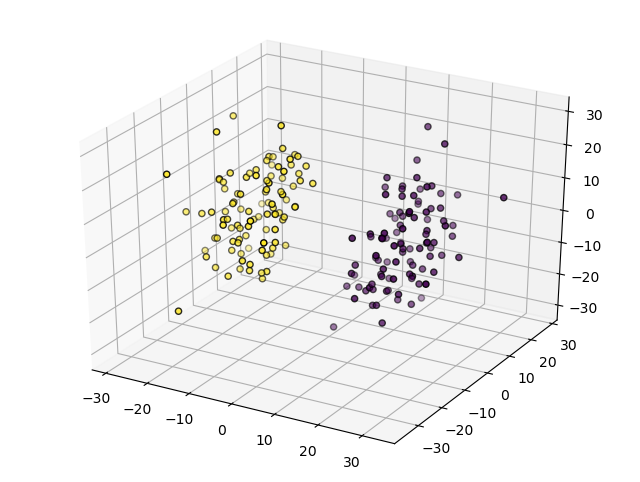

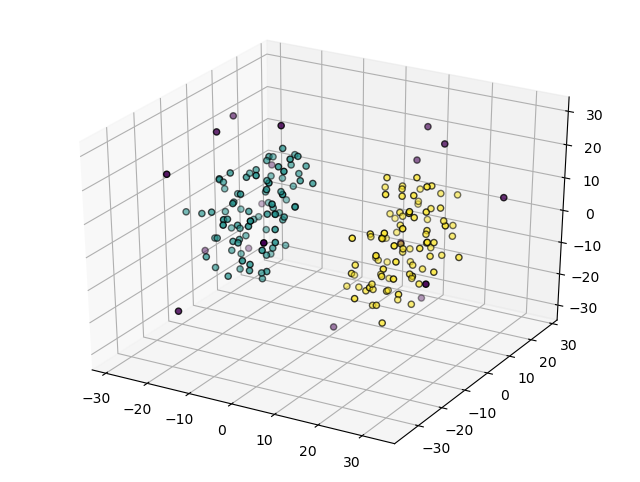

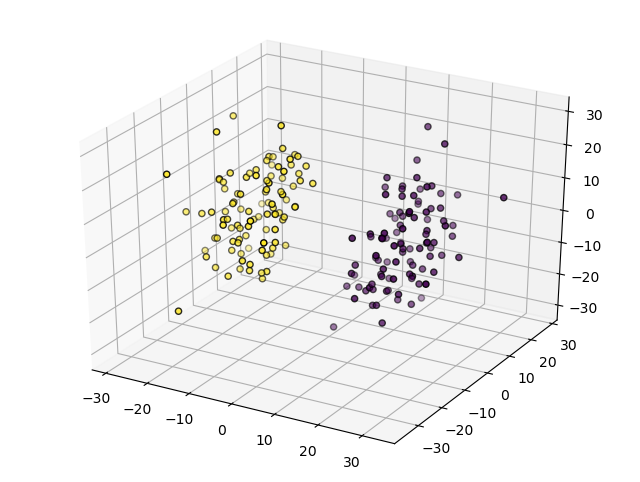

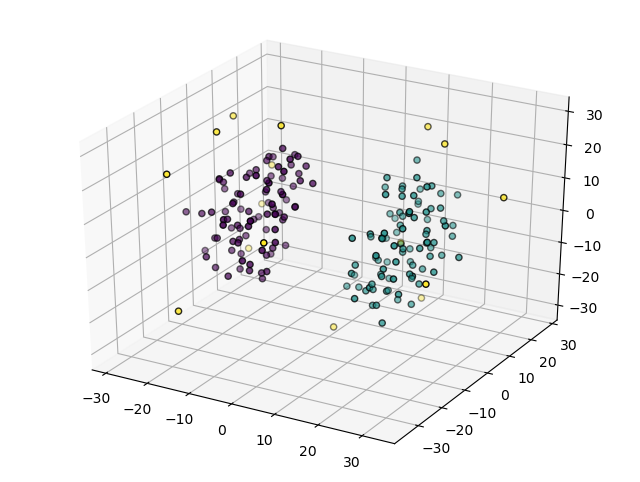

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:,2], c=labels_kmeans, cmap='viridis', edgecolor='k')
# plt.title("MDS Dimensionality Reduction of the Dataset")
# plt.xlabel("MDS1")
# plt.ylabel("MDS2")
# plt.colorbar(label='Class Label')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:,2], c=labels_dbscan, cmap='viridis', edgecolor='k')
# plt.title("MDS Dimensionality Reduction of the Dataset")
# plt.xlabel("MDS1")
# plt.ylabel("MDS2")
# plt.colorbar(label='Class Label')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:,2], c=labels_gmm, cmap='viridis', edgecolor='k')
# plt.title("MDS Dimensionality Reduction of the Dataset")
# plt.xlabel("MDS1")
# plt.ylabel("MDS2")
# plt.colorbar(label='Class Label')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:,2], c=labels_phg, cmap='viridis', edgecolor='k')
# plt.title("MDS Dimensionality Reduction of the Dataset")
# plt.xlabel("MDS1")
# plt.ylabel("MDS2")
# plt.colorbar(label='Class Label')
plt.show()